In [31]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
#define constants
g = 9.80665 #acceleration due to gravity
m = 1    #mass of the bar
l = 0.5      #length of the bar
pi = 3.1415926535
Gamma = 0.9 #Discount factor

TauRange = 2*m*g*l  #max torque is twice of what is required to balances the mass in 90 degree configuration 

res = 3  #resolution of the control input or the totan number of discretized values of the control inpput. This value should ne odd number

ThetaRes = 101 #resolution of theta : creating the discrete state from the originally continouos state theta
                #Odd number in the resolution will ensure that the theta for the vertically up position is included in the discrete state

OmegaRes = 101

OmegaRange = 14

OmegaDisc = np.linspace(-OmegaRange, OmegaRange, OmegaRes)
Ts = 0.05 #50 ms sample time

k = 0.1 #damping constant

ThetaTarget = pi #Angle at which we intend to stabilize

ThetaDisc = np.linspace(0, 2*pi, ThetaRes)
TauDisc = np.linspace(-TauRange, TauRange, res)

def thetaDDot(Theta, Tau):
    return 1.5*g/l*np.sin(Theta) - Tau*3/m/l**2

def reward(Theta, Tau, ThetaTarget):
    #1/(Theta - ThetaTarget + 0.001)
    thetadiff = abs(Theta - ThetaTarget)
    return 1/(thetadiff**10 + 0.00001)

def DynSS(y, t, m,l,k,Tau,g):
    Theta, Omega = y
    dydt = [Omega, -1.5*g/l*np.sin(Theta) + 3*Tau/m/l**2 - 3*k*Omega/m/l**2]
    return dydt

def nextState(y,Tau, Ts):
    y0 = y
    sol = odeint(DynSS, y0, [0, Ts], args=(m,l,k,Tau,g))
    return sol[1,:]

def closestDiscInd(DiscArr, val):
    diff = np.absolute(DiscArr -val)
    Ind = np.argmin(diff)
    return Ind


In [28]:
#TauDisc
TauM = TauDisc[int((res-1)/2 +1)]/2

TauM = 0
print(TauM)
fCount = 0
for theta in ThetaDisc:
    inInd = closestDiscInd(ThetaDisc, theta)
    state = [theta, 0]
    stateN = nextState(state, TauM, Ts)
    finInd = closestDiscInd(ThetaDisc, stateN[0])
    if inInd != finInd:
        #pass
        print(theta, TauM)
        #fCount = fCount + 1
#print('theta not changed : ', fCount/len(ThetaDisc)*100, ' percent')

stateN_test = nextState([1.028, 0], 0, 0.005)
print(stateN_test)

0
1.0279291162252 0
1.0285574347559001 0
1.0291857532866 0
1.0298140718173 0
1.030442390348 0
1.0310707088787 0
1.0316990274094 0
1.0323273459401 0
1.0329556644708 0
1.0335839830015 0
1.0342123015322 0
1.0348406200629 0
1.0354689385936 0
1.0360972571243 0
1.036725575655 0
1.0373538941857 0
1.0379822127164 0
1.0386105312471 0
1.0392388497778 0
1.0398671683085 0
1.0404954868392 0
1.0411238053699 0
1.0417521239006 0
1.0423804424313 0
1.043008760962 0
1.0436370794927 0
1.0442653980234 0
1.0448937165541 0
1.0455220350848 0
1.0461503536155 0
1.0467786721462 0
1.0474069906769 0
1.0480353092076 0
1.0486636277383 0
1.049291946269 0
1.0499202647997 0
1.0505485833304 0
1.0511769018611 0
1.0518052203918 0
1.0524335389225 0
1.0530618574532 0
1.0536901759839 0
1.0543184945146 0
1.0549468130453 0
1.055575131576 0
1.0562034501067 0
1.0568317686374 0
1.0574600871681 0
1.0580884056988 0
1.0587167242295 0
1.0593450427602 0
1.0599733612909 0
1.0606016798216 0
1.0612299983523 0
1.061858316883 0
1.062486635

In [32]:
Q_new = np.zeros((ThetaRes, OmegaRes, res))
def Q_learning(Q_new, ThetaTarget, Ts):
    Theta = pi
    Omega = 0
    Tau = 0
    Iterations = 100000
    eps = 0.1
    TauInd = np.where(TauDisc == Tau)[0][0]
    ThetaHist = [Theta]
    CritThetaCount = 0
    ThetaVisitCount = np.zeros(ThetaRes)
    Q = np.copy(Q_new)
    for i in range(Iterations):
        #First find the next state
        Theta_n, Omega_n = nextState([Theta, Omega], Tau, Ts)
        if Theta_n >= 2*pi:
            Theta_n = Theta_n - 2*pi
        elif Theta_n < 0:
            Theta_n = Theta_n + 2*pi
        ThetaHist.append(Theta_n)

        if Omega_n > OmegaRange:
            print('Omega exceeding the bounds, stopping learning')
            break

        #Update the Q function
        #First find the closest Theta value in the discretized theta to the current Theta and Theta_n
        
        ThetaInd = closestDiscInd(ThetaDisc, Theta)
        Theta_nInd = closestDiscInd(ThetaDisc, Theta_n)
        OmegaInd = closestDiscInd(OmegaDisc, Omega)
        Omega_nInd = closestDiscInd(OmegaDisc, Omega_n)
        Q_new = np.copy(Q)
        f_term = Q[ThetaInd, TauInd]
        s_term = reward(ThetaDisc[ThetaInd], Tau, ThetaTarget) + Gamma*Q[Theta_nInd, Omega_nInd, :].max()
        print(f_term)
        print(s_term)
        Q_new[ThetaInd, OmegaInd, TauInd] = (1-eps)*f_term + eps*s_term
        
        # print(f_term, s_term)
        # print('ThetaInd, TauInd', ThetaInd, TauInd)
        # print('s_term1: ', reward(ThetaDisc[ThetaInd], Tau, ThetaTarget), 's_term2: ', Gamma*Q[Theta_nInd, :].max())
        # print('Q[Theta_nInd, :]',Q[Theta_nInd, :])
        # print('theta', ThetaDisc[ThetaInd])
        # print('Tau: ', Tau, 'Theta_n: ', Theta_n )

        #print(Q_new)
        
        #generate a random action for the next instant
        TauInd = np.random.randint(res)
        Tau = TauDisc[TauInd]
        

        Theta, Omega = OmegaDisc[Theta_nInd], OmegaDisc[Omega_nInd]
        Q = np.copy(Q_new)
        if i%100000 == 0:
            print(i/100000, "Q-update", f_term- s_term)
            
    #print(CritThetaCount/Iterations*100, "Explored critical region")
    return Q_new, ThetaHist

Q, ThetaHist = Q_learning(Q_new, ThetaTarget, Ts)


ValueError: setting an array element with a sequence.

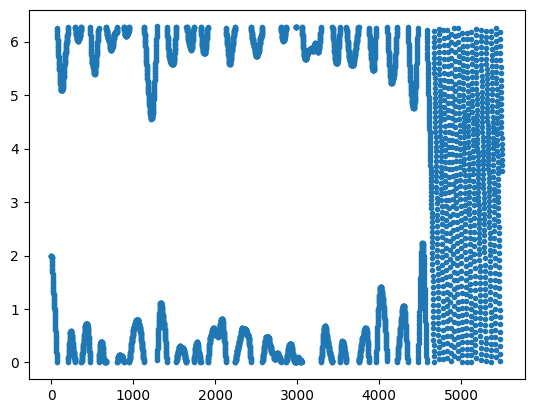

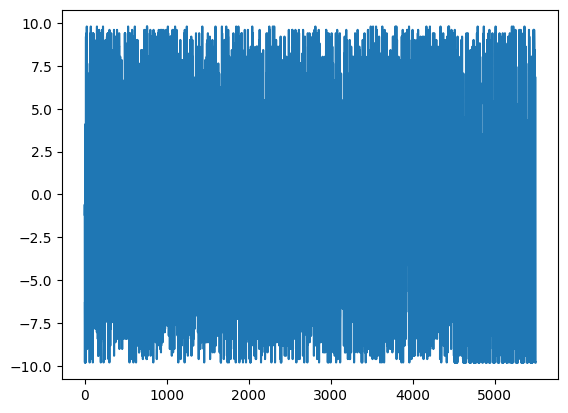

In [8]:
# Controling pendulum using the learned Q-function
Theta0 = 2
Omega0 = 0

# Want to stabilize the Theta at pi (Vertically inverted)

simIter = 5500
Theta, Omega = Theta0, Omega0
ThetaSim = [Theta]
TauSim = []
for i in range(simIter):
        
    diff = np.absolute(ThetaDisc - Theta)
    ThetaInd = np.argmin(diff)

    #Finding optimal action for the current state

    optTauInd = np.argmax(Q[ThetaInd, :])
    optTau = TauDisc[optTauInd]
    TauSim.append(optTau)
    Theta_n, Omega_n = nextState([Theta, Omega], optTau, Ts)
    if Theta_n >= 2*pi:
        Theta_n = Theta_n - 2*pi
    elif Theta_n < 0:
        Theta_n = Theta_n + 2*pi
    ThetaSim.append(Theta_n)
    Theta, Omega = Theta_n, Omega_n

plt.figure(1)
plt.plot(ThetaSim, '.')
plt.figure(2)
plt.plot(TauSim)



In [13]:
for i in range(90,120):
    print(ThetaSim[i], TauSim[i])

1.2448063085811967 2.549729000000001
1.3543551258948436 5.295591
1.5024493623541233 9.022118
1.7798888381995077 2.157463
2.1338789250192547 1.7651970000000006
2.464518132644369 7.6491869999999995
2.869987644286082 0.19613300000000145
3.3467056113237055 -2.157462999999999
3.780972656841607 -2.745861999999999
4.1603561600749 -3.5303939999999994
4.486213946825904 -5.883989999999999
4.724684115459678 -9.022117999999999
4.803007540923939 -6.472389
4.7227223718762295 -9.022117999999999
4.492405618235737 -5.883989999999999
4.127856106417147 6.080123
3.8482457660253733 3.726527000000001
3.7744542627422275 -9.414384
3.662241750991835 -8.825985
3.325220606744715 -1.1767979999999998
2.875384341116585 -8.041452999999999
2.2972650445738676 6.864655000000001
1.6860044488838664 7.453054
1.249671830469616 2.549729000000001
0.9165549969421642 -2.5497289999999992
0.5461962452775626 3.3342610000000015
0.1732040096414664 -1.1767979999999998
6.123579945805841 -5.099457999999999
5.72990743315376 -8.825985
5

In [17]:
closestDiscInd(ThetaDisc, 2.133878925019254)
Q[170, :]

array([25230.61545622, 27011.69918418, 29178.71026792, 26132.72233843,
       28156.58584582, 25625.38035889, 28013.53919594, 27824.07518993,
       25572.48028229, 25474.43449625, 26993.96780077, 25096.5836829 ,
       27871.3566984 , 25150.54434511, 29389.66997786, 25694.24600464,
       29713.38161292, 24282.5558864 , 25961.50722456, 27415.9261189 ,
       30511.77029116, 25092.40379803, 29328.23092911, 29309.40766934,
       26094.1697278 , 25685.55663448, 25893.41677687, 28559.39570062,
       26261.29004308, 27707.98340025, 27880.04680831, 26946.72324127,
       27649.40966877, 29234.58176875, 28569.71958615, 26416.38528227,
       25134.66525881, 28759.32834712, 29998.71736407, 30822.54575385,
       25836.41679621, 28046.5355498 , 27230.85433047, 26901.58155867,
       28659.55751078, 27328.5509733 , 28692.37716031, 30515.21574433,
       27869.99238968, 31986.79831576, 28607.8817975 , 30649.68277058,
       31192.25484261, 29599.72740092, 31650.49344065, 30553.77156728,
      